### Look into distribution of number of classifications made per user for `classify_classifications.csv`:

In [36]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
from dateutil.parser import parse

import sys
sys.path.append('..')
from sf import getFilename, parseTime, extract_task_value, percentageVotesForAnswer, extractTaskValue, get_power_users, make_df_vote_threshold
from datetime import date
from collections import OrderedDict, Counter

%matplotlib inline

In [35]:
# reload sf import while I'm working on extracting functionality to it from notebooks
from importlib import reload
import sf
reload(sf)

<module 'sf' from '..\\sf.py'>

In [3]:
font = {
    'family': 'Verdana',
    'weight': '300',
    'size': 12
}

rc('font', **font)

- ### Extract and parse dataframe:

In [4]:
# load dataframe
df = pd.read_csv('./df.csv', delimiter=",")

# inspect column names
print(df.keys())

Index(['classification_id', 'user_name', 'user_id', 'user_ip', 'workflow_id',
       'workflow_name', 'workflow_version', 'created_at', 'gold_standard',
       'expert', 'metadata', 'annotations', 'subject_data', 'subject_ids',
       'Filename', 'Task0', 'Task1', 'retired'],
      dtype='object')


- ### Look into distribution of votes per user:

In [5]:
users = df['user_name']

print('Unique users by name: {}'.format(users.unique().shape[0]))
print('Unique users by id: {}'.format(df['user_id'].unique().shape[0]))

Unique users by name: 1783
Unique users by id: 1136


@note: Users not logged in don't get assigned an id (see next cell), so don't use the user_id field for this!

In [6]:
# df[df['user_id'].isnull()].head()

In [7]:
groupby_username = df.groupby(['user_name'])

In [8]:
classifications_per_user = np.array([len(classifications) for (user_name, classifications) in groupby_username])

In [9]:
basic_count_stats = {
    'median': np.median(classifications_per_user),
    'mean': np.mean(classifications_per_user),
    'st. dev': np.std(classifications_per_user)
}

basic_count_stats

{'median': 14.0, 'mean': 52.09927089175547, 'st. dev': 175.81668649844124}

In [10]:
unique_classification_counts = set(classifications_per_user)

In [11]:
occurrences = OrderedDict(sorted(Counter(classifications_per_user).items()))

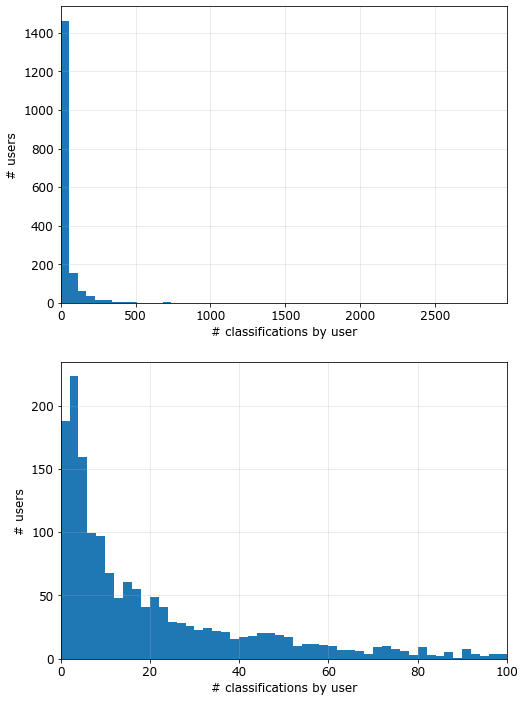

In [12]:
fig, fr = plt.subplots(2,1, figsize=(8,12))

fr[0].hist(classifications_per_user, bins=50)
fr[0].update({
    'xlim': (0),
})

fr[1].hist(classifications_per_user, range=[0,100], bins=50)
fr[1].update({
    'xlim': (0, 100),
    
})

for i in range(2):
    fr[i].grid(which='both', alpha=0.3)
    fr[i].update({
        'xlabel': '# classifications by user',
        'ylabel': '# users'
    })

In [13]:
# from pprint import pprint

# pprint(occurrences)

In [18]:
def percentage_votes_within_limit(classifications_per_user, limit):
    return round(100*len(classifications_per_user[classifications_per_user <= limit])/len(classifications_per_user), 1)

In [19]:
for limit in [25, 50, 100, 250, 500, 1000]:
    print('% of people with <= {:>4} classifications: {}'.format(limit, percentage_votes_within_limit(classifications_per_user, limit)))

% of people with <=   25 classifications: 64.9
% of people with <=   50 classifications: 79.6
% of people with <=  100 classifications: 89.0
% of people with <=  250 classifications: 96.5
% of people with <=  500 classifications: 98.8
% of people with <= 1000 classifications: 99.5


- ## Inspect general voting behavior of power users

In [115]:
threshold = 200

In [116]:
pu = get_power_users(df, threshold)
pu_usernames = [user['username'] for user in pu]

In [117]:
df_threshold = make_df_vote_threshold(df, threshold)
groupby_username = df_threshold.groupby(['user_name'])

In [118]:
answers = ['Galaxy', 'Group of objects (Cluster)', 'Something else/empty center']
values = [[], [], []]
per_user = []

for username in pu_usernames:
    df_user = groupby_username.get_group(username)
    
    value_counts_normed = df_user['Task0'].value_counts(normalize=True)
    value_counts = df_user['Task0'].value_counts()
    
    user_obj = {
        "username": username
    }
    
    for i, answer in enumerate(answers):
        try:
            values[i].append(value_counts_normed[answer])
        except:
            values[i].append(0)
            
        try:
            user_obj[answer] = value_counts[answer]
        except:
            user_obj[answer] = 0
    
    per_user.append(user_obj)
    
values = np.array(values)

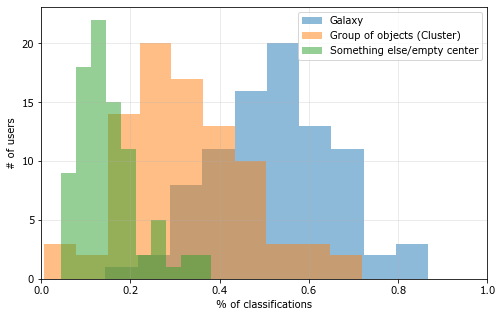

In [121]:
fig, fr = plt.subplots(figsize=(8,5))

for i in range(3):
    fr.hist(values[i], alpha=0.5, label=answers[i])
    
fr.legend()
fr.update({
    'xlim': [0,1],
    'xlabel': '% of classifications',
    'ylabel': '# of users'
})
fr.grid(alpha=0.3, which='both')

plt.show()